In [ ]:
BATCH_SIZE = 64
N_CHANNELS = 5

In [ ]:
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torch
from network_definitions.u_net import UNet
from network_definitions.fcn import FCN32s as FCN
from network_definitions.simple_network import SimpleNet
from torchvision.models.segmentation import fcn_resnet101 as FCN_Res101

# Dataset Import

In [ ]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pickle

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

class EnsembleDataset(Dataset):
    """Ensemble dataset."""

    def __init__(self, results_file, transform=None):
        """
        Args:
            results_file (string): File with all the results.
        """
        with open(results_file, 'rb') as f:
            #compressed_file = bz2.BZ2File(f, 'r')
            self.results = pickle.load(f)
        self.transform = transform

    def __len__(self):
        return len(self.results)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        data = self.results[idx]
        sample = {'name': data[0], 'im_seg': data[1], 'im_res': data[2]}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
from skimage.transform import resize
from torchvision import transforms, utils

class Resize(object):
    def __init__(self, size):
        self.size = size

    def __call__(self,sample):
        name,im_seg,im_res = sample["name"],sample["im_seg"],sample["im_res"]
        
        return {"name": name, "im_seg": resize(im_seg,(self.size,self.size,N_CHANNELS),preserve_range=True), "im_res": resize(im_res,(self.size,self.size,1),preserve_range=True)}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        name,im_seg,im_res = sample["name"],sample["im_seg"],sample["im_res"]

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        im_seg = im_seg.transpose((2, 0, 1))
        im_res = im_res.transpose((2, 0, 1))
        return {"name": name, 
                "im_seg": torch.from_numpy(im_seg),
                "im_res": torch.from_numpy(im_res)}

In [5]:
trainset = EnsembleDataset(results_file='work_dirs/dataset_generation/dataset_no_img.pkl', 
                           transform=transforms.Compose([Resize(572),
                                                         ToTensor()]))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=6)

"""trainset = EnsembleDataset(image_dir='data/coco/test2017',
                           results_file='',
                           transform=transforms.Compose([Rescale(256),
                                                         RandomCrop(224),
                                                         ToTensor()]))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)"""



"trainset = EnsembleDataset(image_dir='data/coco/test2017',\n                           results_file='',\n                           transform=transforms.Compose([Rescale(256),\n                                                         RandomCrop(224),\n                                                         ToTensor()]))\ntrainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,\n                                          shuffle=True, num_workers=2)"

# Training

In [6]:
from torch.utils.tensorboard import SummaryWriter

#PATH = "work_dirs/simplenet_1/"


def train(net, trainloader, criterion, optimizer, save_path, tensorboard_path, checkpoint=None):
    
    EPOCH = 0
    
    writer = SummaryWriter(log_dir=tensorboard_path)
    
    if checkpoint != None:
        checkpoint = torch.load(checkpoint)
        net.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        EPOCH = checkpoint['epoch']
        loss = checkpoint['loss']
        net.train()
    
    for epoch in range(EPOCH,25):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            im_seg = data["im_seg"].to(device, dtype=torch.float)
            im_res = data["im_res"].to(device, dtype=torch.float)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            output = net(im_seg.float())
            loss = criterion(output, im_res.float())
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 50 == 49:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.6f' %
                      (epoch + 1, i + 1, running_loss / 50))
                running_loss = 0.0
                inp = im_seg.cpu().detach()
                output = output.cpu().detach()
                gt_output = im_res.cpu().detach()
                
                inp = inp.numpy()[0].transpose((1,2,0))
                #.squeeze(axis=0)
                output = output.numpy()[0].transpose((1,2,0)).squeeze(axis=2)
                gt_output = gt_output.numpy()[0].transpose((1,2,0)).squeeze(axis=2)
                
                fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(15,15))
                ax=ax.flat
                
                for i in range(0,5):
                    #ax.append(fig.add_subplot(2, 4, i+1))
                    ax[i].set_title("Input "+str(i+1))  # set title
                    ax[i].imshow(inp[:,:,i],cmap='gray',vmin=0,vmax=1)
                    
                
                    
                #ax.append(fig.add_subplot(2, 4, 6))
                ax[5].set_title("Output")  # set title
                ax[5].imshow(output,cmap='gray',vmin=0,vmax=1)
                
                #ax.append(fig.add_subplot(2, 4, 7))
                ax[6].set_title("GT Output")  # set title
                ax[6].imshow(gt_output,cmap='gray',vmin=0,vmax=1)
                
                fig.tight_layout()

                plt.show()
                
                print(inp[:,:,i].max(),inp[:,:,i].min())
                print(output.max(),output.min())
            
        writer.add_scalar('Loss', loss, epoch)

        if epoch % 5 == 4:        
            torch.save({
                'epoch': epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, save_path+"epoch_"+str(epoch+1)+".pt")
    
    writer.close()

    print('Finished Training')

Starting training on network  [1]
[1,    50] loss: 0.588963


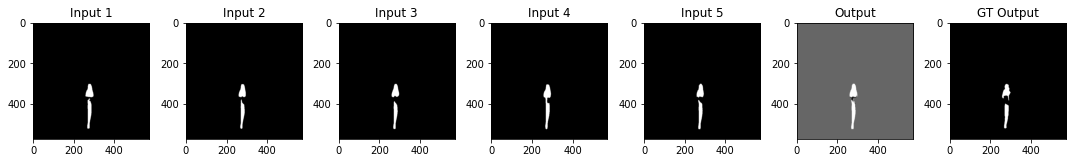

1.0 0.0
0.9988164 0.06889422
[1,   100] loss: 0.503119


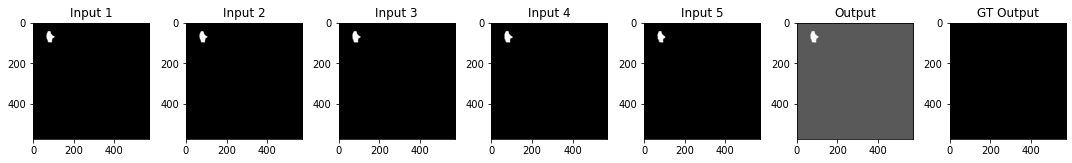

1.0 0.0
0.9867046 0.3541497
[1,   150] loss: 0.442319


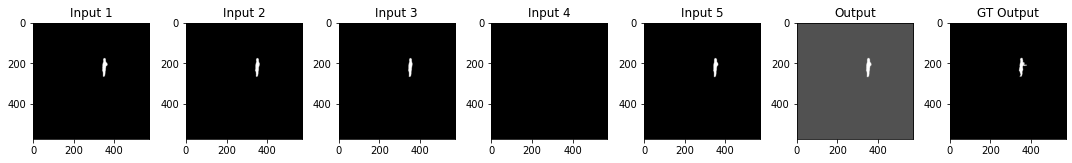

1.0 0.0
0.9990128 0.32249126
[2,    50] loss: 0.354289


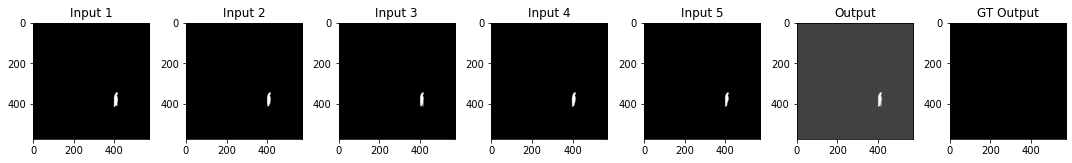

1.0 0.0
0.9785822 0.08920852
[2,   100] loss: 0.318865


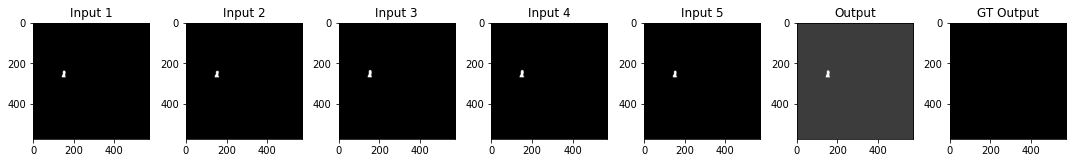

1.0 0.0
0.98423856 0.076174274
[2,   150] loss: 0.293397


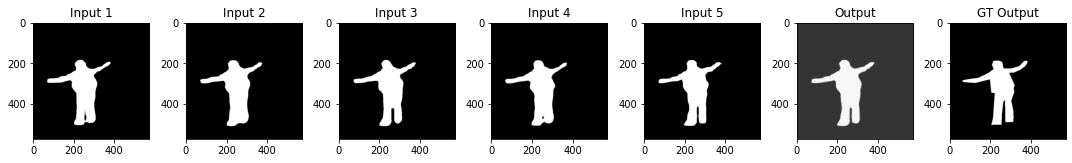

1.0 0.0
0.98741865 0.08344469
[3,    50] loss: 0.246440


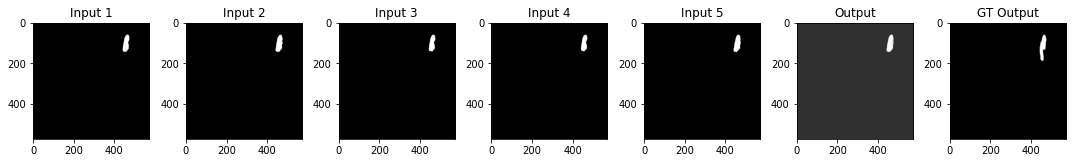

1.0 0.0
0.99315065 0.18884562
[3,   100] loss: 0.233212


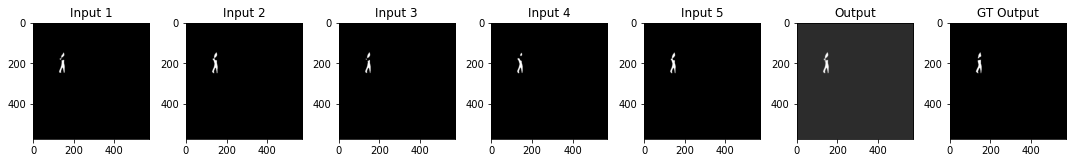

1.0 0.0
0.99658525 0.06480945
[3,   150] loss: 0.218864


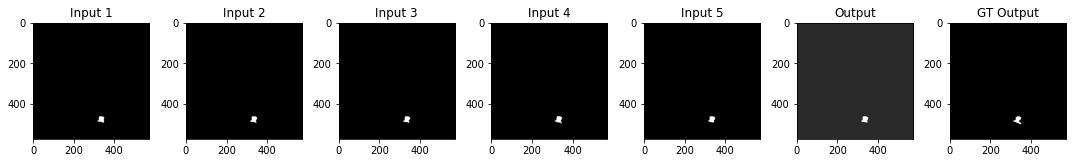

1.0 0.0
0.99345714 0.06583013
[4,    50] loss: 0.192848


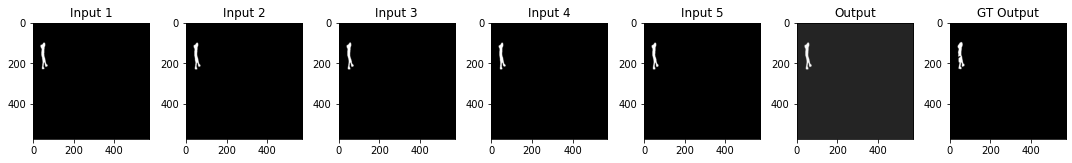

1.0 0.0
0.9912164 0.07645242
[4,   100] loss: 0.179606


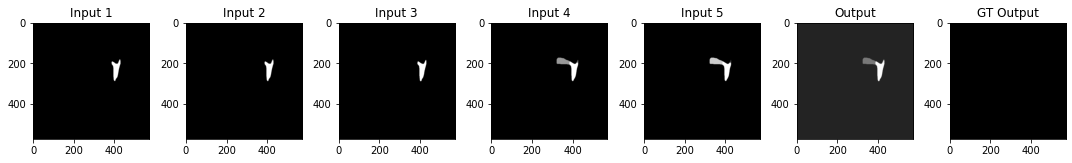

1.0 0.0
0.9855333 0.139842
[4,   150] loss: 0.175144


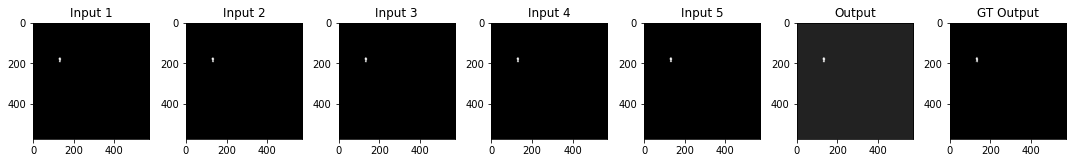

1.0 0.0
0.99327326 0.13355012
[5,    50] loss: 0.157717


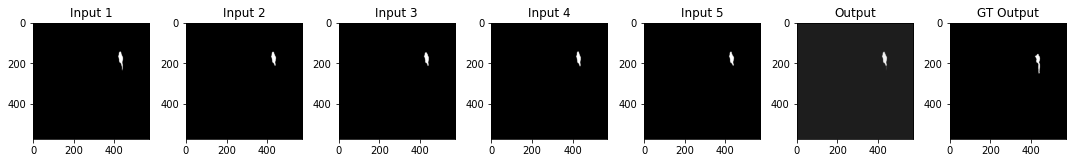

1.0 0.0
0.9698546 0.08911607
[5,   100] loss: 0.148523


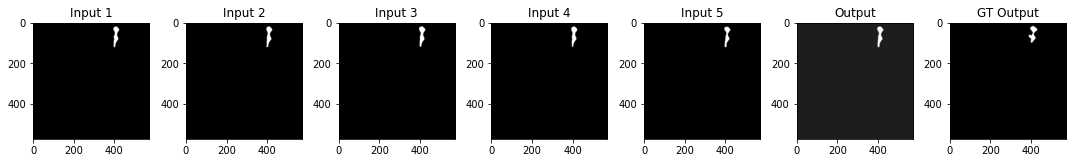

1.0 0.0
0.98664135 0.067762904
[5,   150] loss: 0.146352


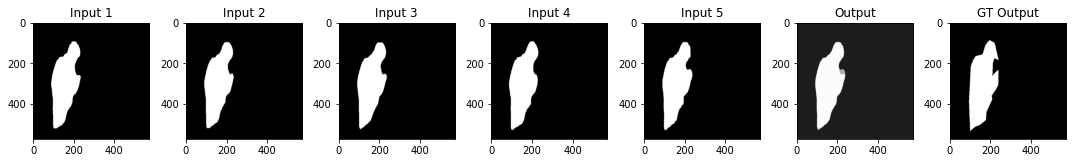

1.0 0.0
0.99366647 0.059092175
[6,    50] loss: 0.132975


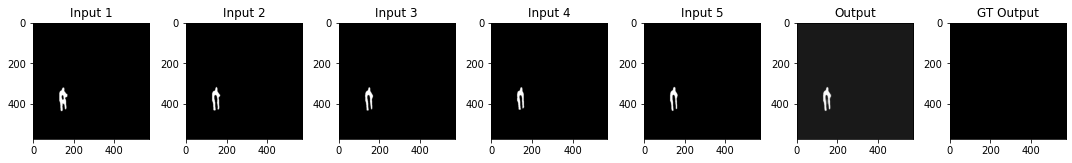

1.0 0.0
0.98803085 0.060116995
[6,   100] loss: 0.130459


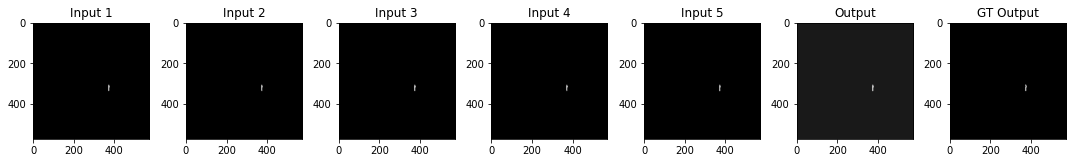

1.0 0.0
0.992733 0.082445234
[6,   150] loss: 0.123940


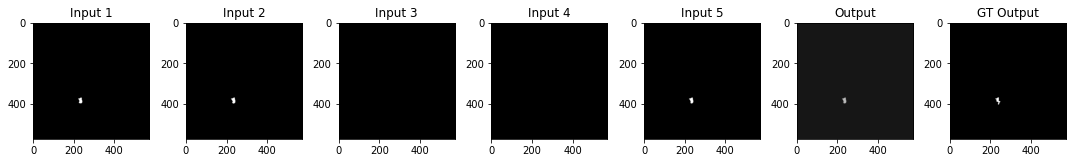

1.0 0.0
0.72933656 0.088648595
[7,    50] loss: 0.118496


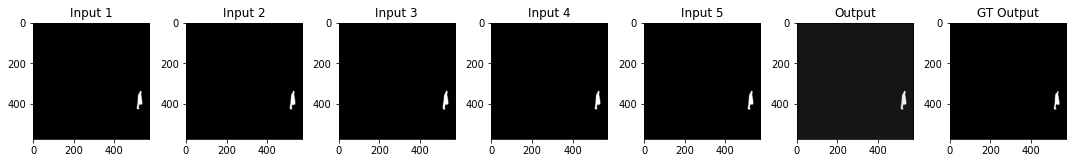

1.0 0.0
0.95232856 0.060513284
[7,   100] loss: 0.111463


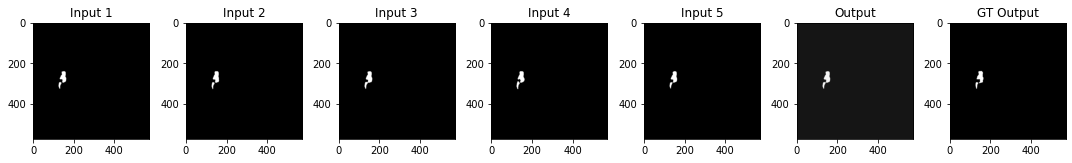

1.0 0.0
0.9732343 0.058827993
[7,   150] loss: 0.109522


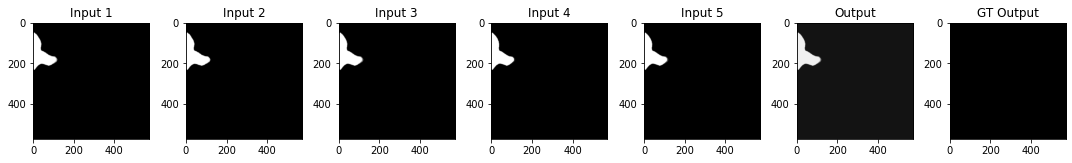

1.0 0.0
0.9407368 0.07800409
[8,    50] loss: 0.105673


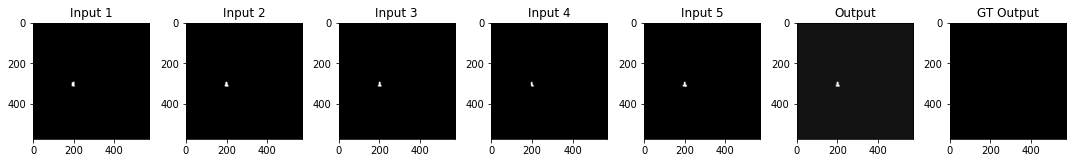

1.0 0.0
0.98220575 0.07546944
[8,   100] loss: 0.100100


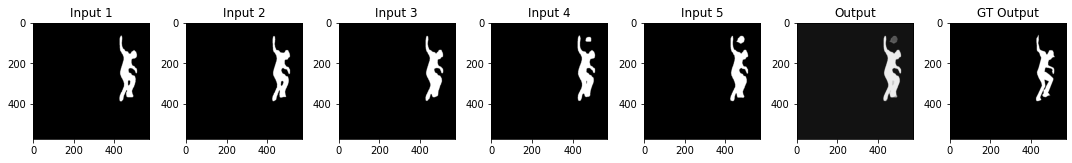

1.0 0.0
0.9420622 0.05715088
[8,   150] loss: 0.097332


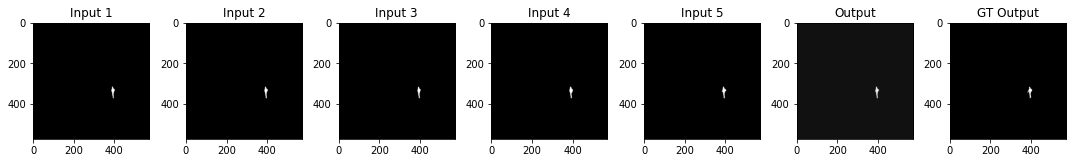

1.0 0.0
0.9380844 0.05646716
[9,    50] loss: 0.094579


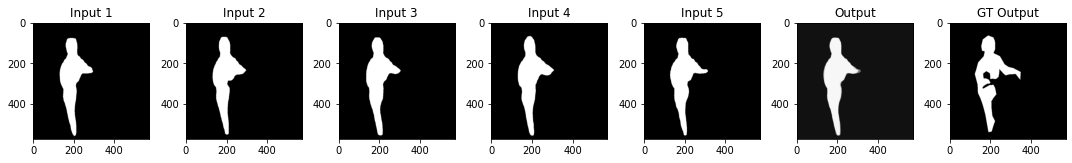

1.0 0.0
0.97249866 0.056492016
[9,   100] loss: 0.093289


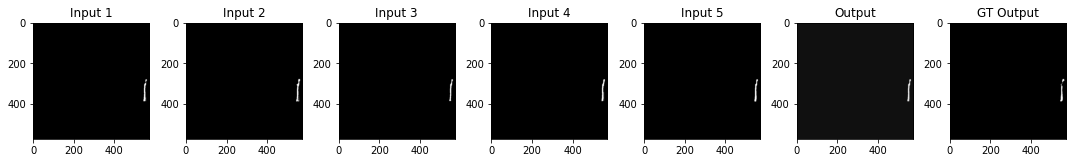

1.0 0.0
0.9564849 0.057144266
[9,   150] loss: 0.090178


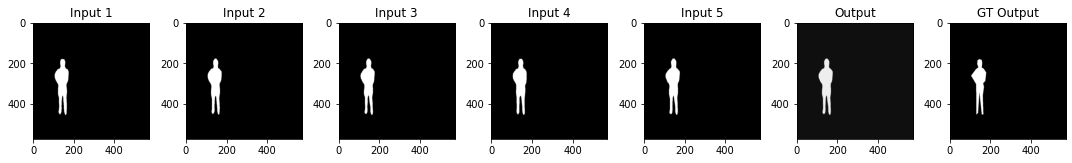

1.0 0.0
0.93630373 0.055442125
[10,    50] loss: 0.086073


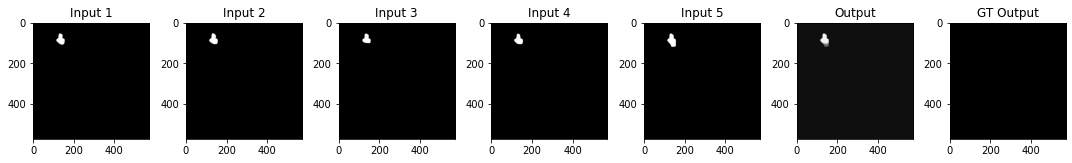

1.0 0.0
0.9565769 0.057000767
[10,   100] loss: 0.085055


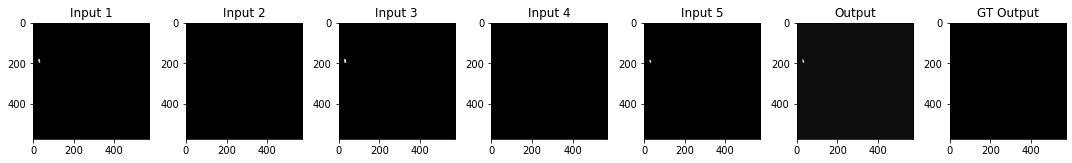

1.0 0.0
0.8553935 0.056275725
[10,   150] loss: 0.084478


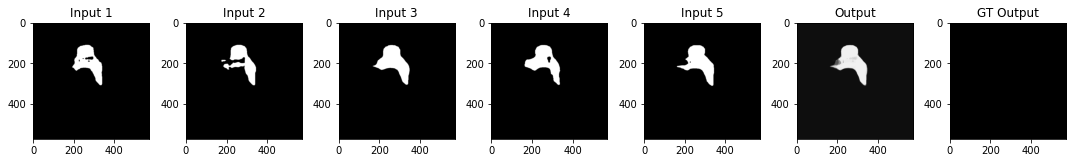

1.0 0.0
0.9459694 0.054205645
[11,    50] loss: 0.078382


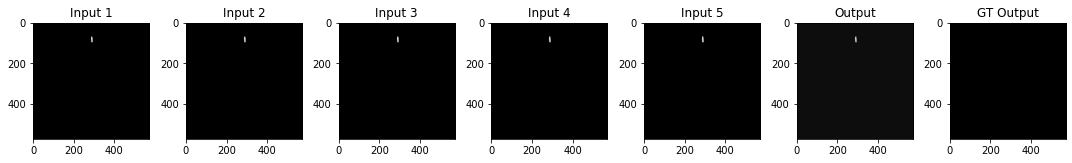

1.0 0.0
0.9186896 0.05371539
[11,   100] loss: 0.080621


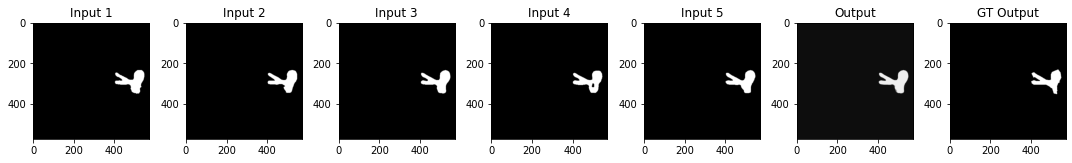

1.0 0.0
0.93508893 0.05295349
[11,   150] loss: 0.078659


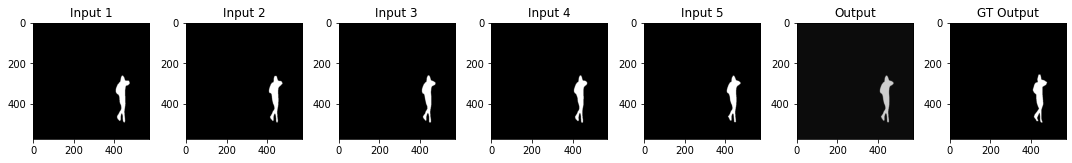

1.0 0.0
0.80853677 0.049249403
[12,    50] loss: 0.076249


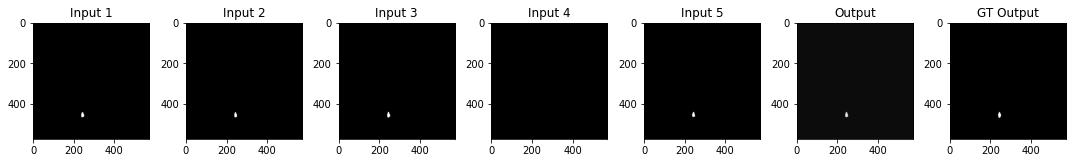

1.0 0.0
0.8978616 0.048436802
[12,   100] loss: 0.075379


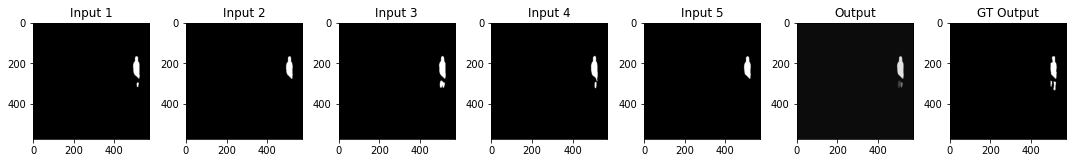

1.0 0.0
0.885761 0.047626086
[12,   150] loss: 0.074324


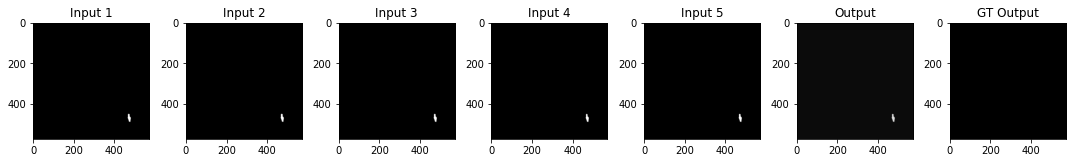

1.0 0.0
0.85960925 0.04641047
[13,    50] loss: 0.073141


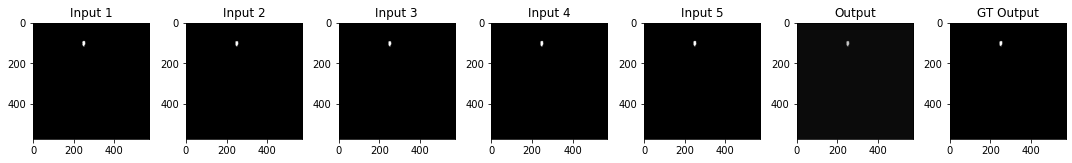

1.0 0.0
0.7759246 0.043410964
[13,   100] loss: 0.069707


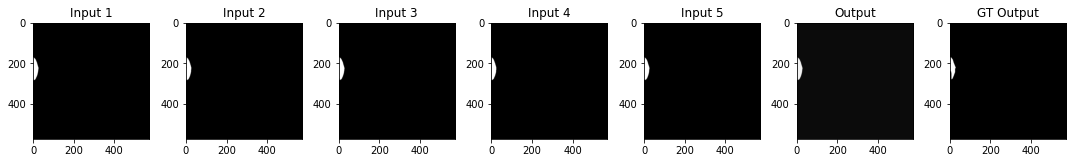

1.0 0.0
0.94554716 0.04517813
[13,   150] loss: 0.070446


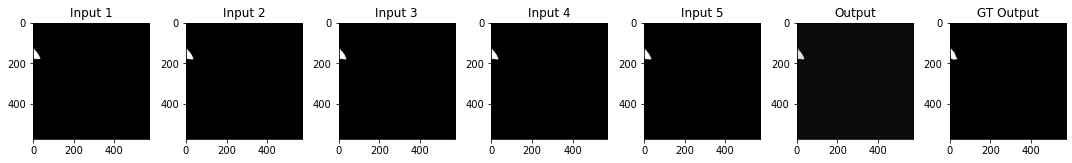

1.0 0.0
0.8845848 0.04327952
[14,    50] loss: 0.068610


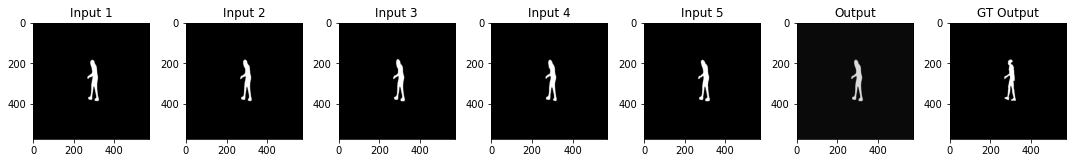

1.0 0.0
0.8574285 0.04124195
[14,   100] loss: 0.067799


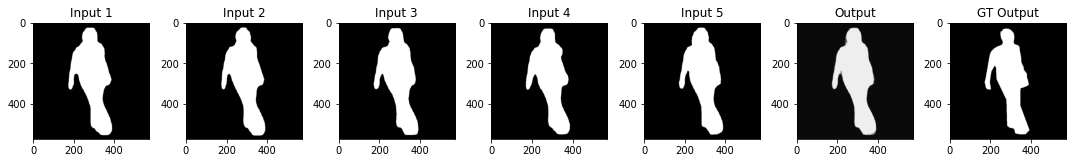

1.0 0.0
0.9325934 0.041931223
[14,   150] loss: 0.065809


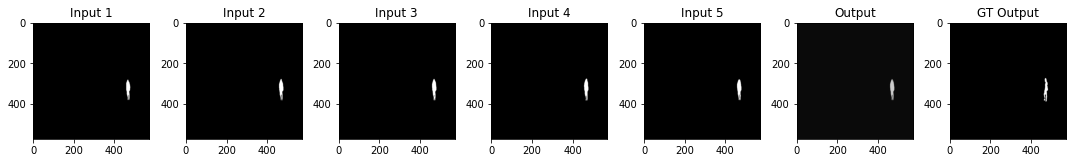

1.0 0.0
0.7973195 0.039213464
[15,    50] loss: 0.065047


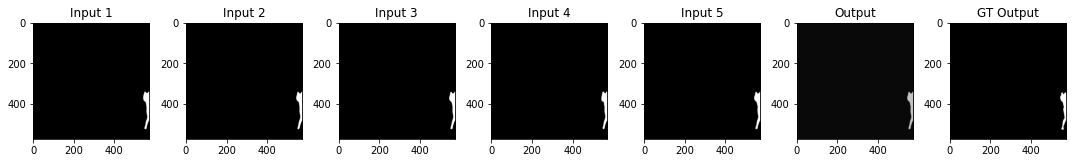

1.0 0.0
0.7594283 0.037713155
[15,   100] loss: 0.065859


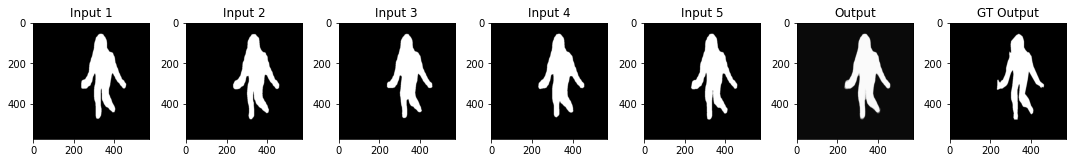

1.0 0.0
0.9769031 0.039968964
[15,   150] loss: 0.064150


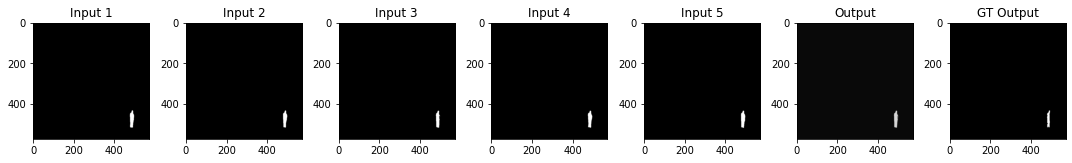

1.0 0.0
0.83825606 0.037176244
[16,    50] loss: 0.063015


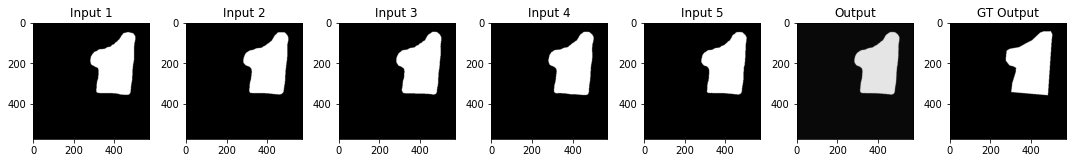

1.0 0.0
0.8955421 0.036678407
[16,   100] loss: 0.062750


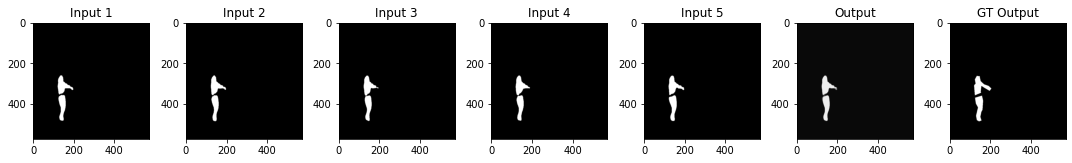

1.0 0.0
0.93344617 0.03680091
[16,   150] loss: 0.063239


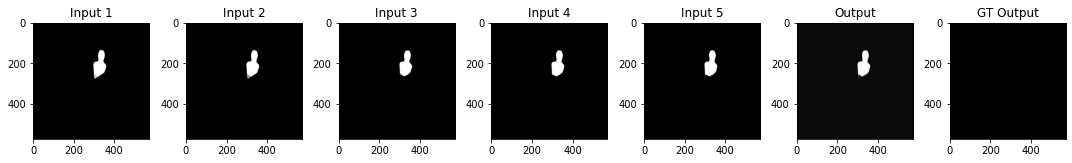

1.0 0.0
0.97779137 0.03707984
[17,    50] loss: 0.061543


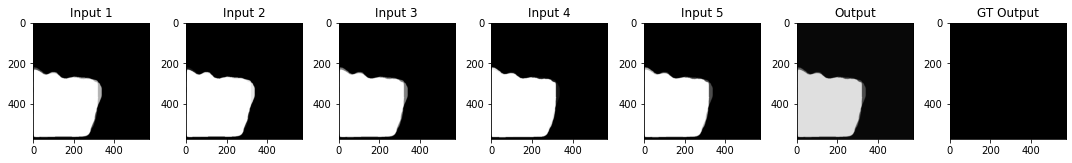

1.0 0.0
0.874167 0.034452785
[17,   100] loss: 0.061282


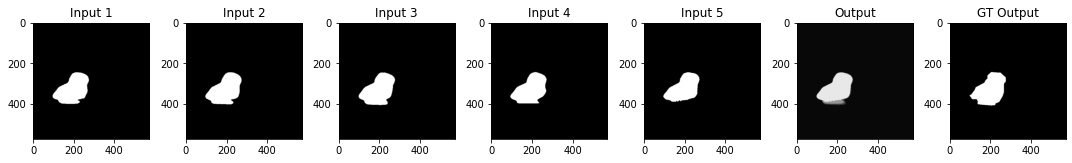

1.0 0.0
0.9101191 0.034241896
[17,   150] loss: 0.059052


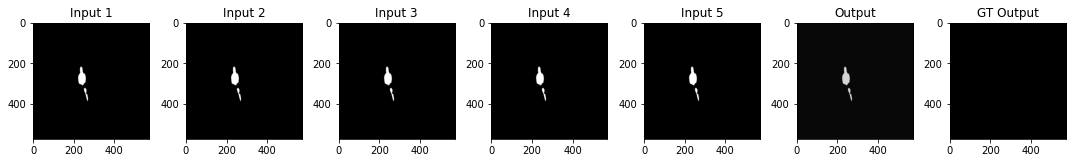

1.0 0.0
0.8327995 0.032919567
[18,    50] loss: 0.058412


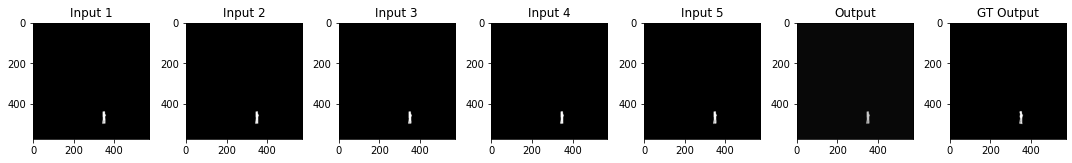

1.0 0.0
0.7944201 0.031793967
[18,   100] loss: 0.059532


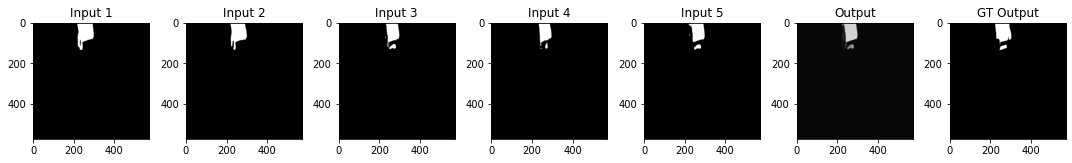

1.0 0.0
0.82452804 0.031554766
[18,   150] loss: 0.058112


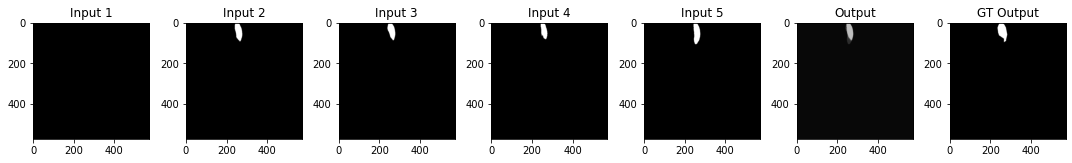

1.0 0.0
0.7459242 0.031805042
[19,    50] loss: 0.057903


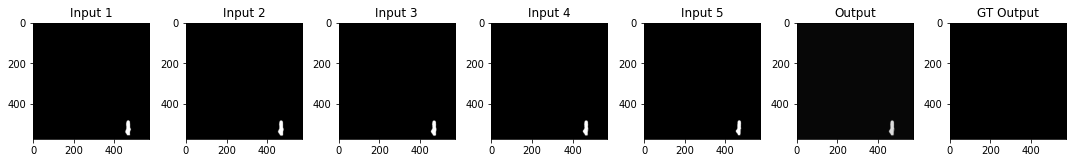

1.0 0.0
0.85837126 0.030592585
[19,   100] loss: 0.056565


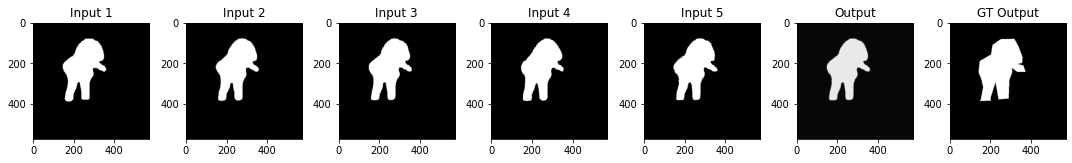

1.0 0.0
0.9121698 0.030965038
[19,   150] loss: 0.056949


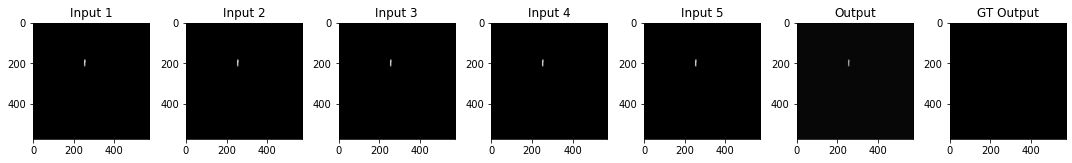

1.0 0.0
0.78488696 0.029355569
[20,    50] loss: 0.056874


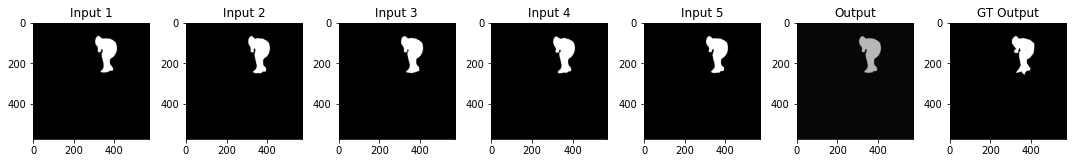

1.0 0.0
0.7179357 0.028134637
[20,   100] loss: 0.055971


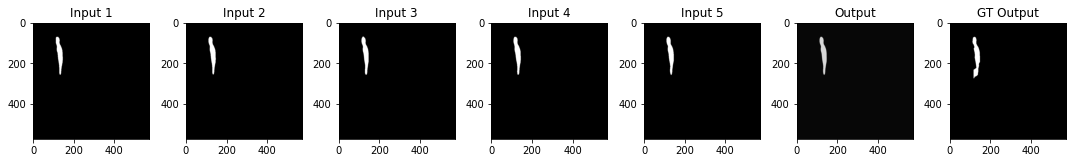

1.0 0.0
0.8449934 0.028775437
[20,   150] loss: 0.055957


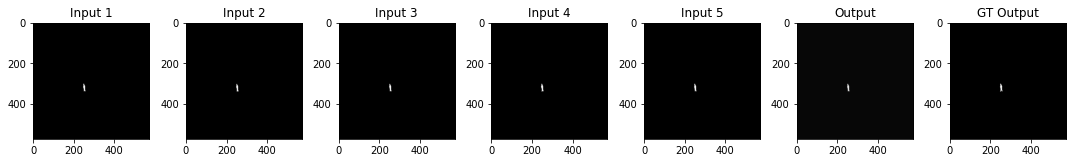

1.0 0.0
0.9430193 0.0295172
[21,    50] loss: 0.056625


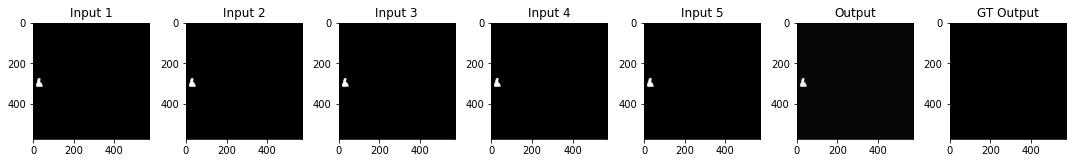

1.0 0.0
0.9343971 0.028597975
[21,   100] loss: 0.053938


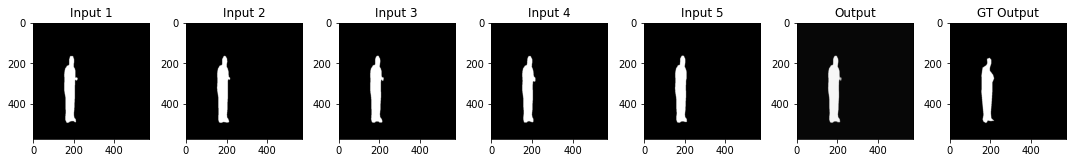

1.0 0.0
0.9634875 0.028763637
[21,   150] loss: 0.054444


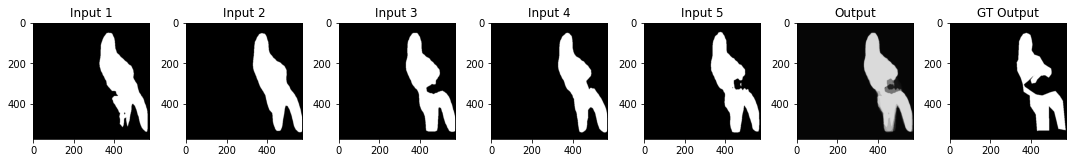

1.0 0.0
0.8529734 0.027175799
[22,    50] loss: 0.053297


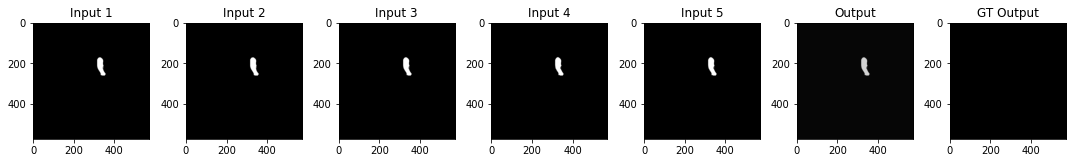

1.0 0.0
0.8244143 0.026463889
[22,   100] loss: 0.053308


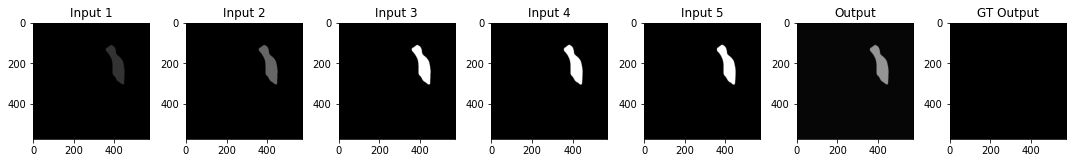

1.0 0.0
0.5822238 0.025231048
[22,   150] loss: 0.054304


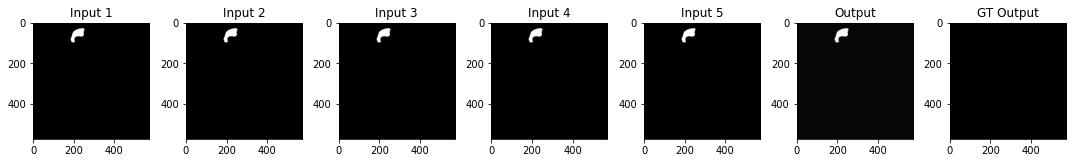

1.0 0.0
0.9709346 0.027304884
[23,    50] loss: 0.053181


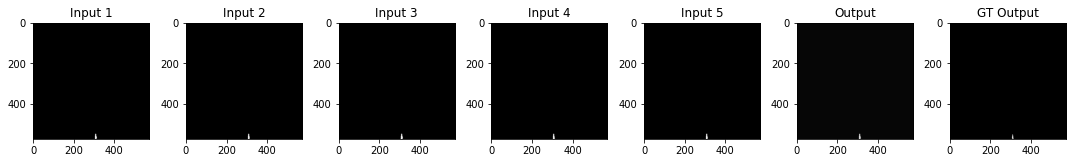

1.0 0.0
0.9053107 0.025557715
[23,   100] loss: 0.054105


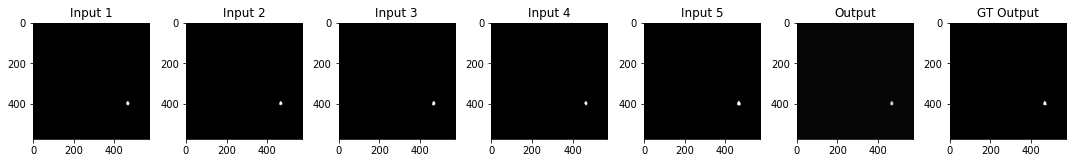

1.0 0.0
0.83161956 0.024916204
[23,   150] loss: 0.052206


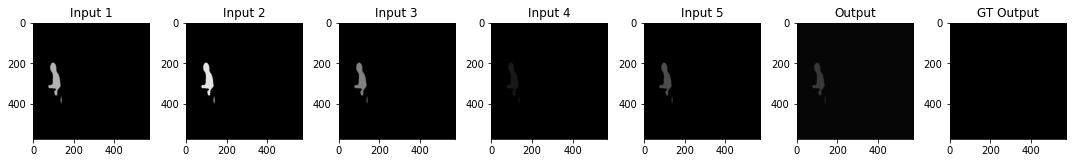

0.3 0.0
0.22327745 0.024790298
[24,    50] loss: 0.050890


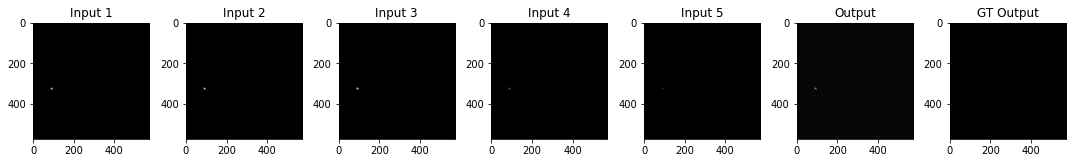

0.2 0.0
0.6884119 0.025316563
[24,   100] loss: 0.052451


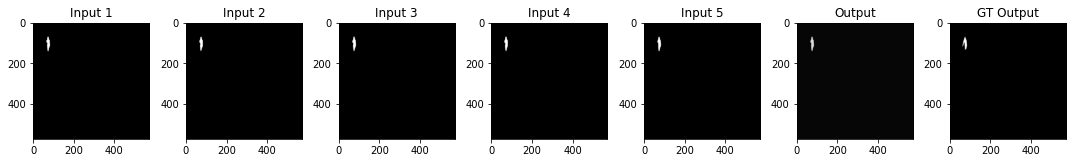

1.0 0.0
0.8566618 0.024137761
[24,   150] loss: 0.051309


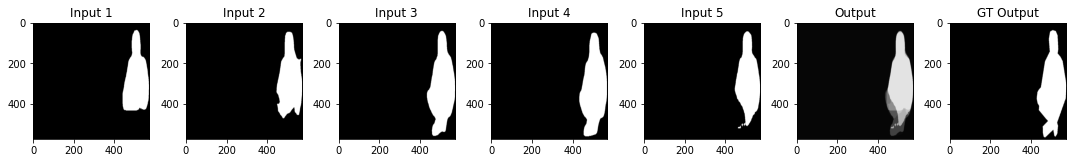

1.0 0.0
0.8930769 0.024270179
[25,    50] loss: 0.050701


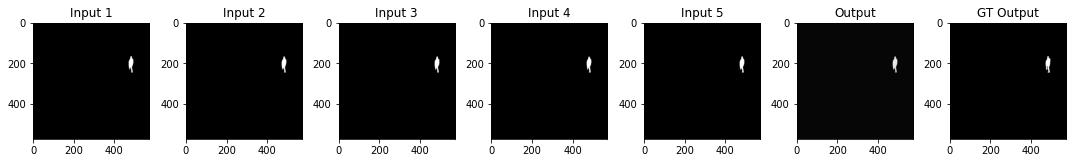

1.0 0.0
0.9104856 0.024002368
[25,   100] loss: 0.049292


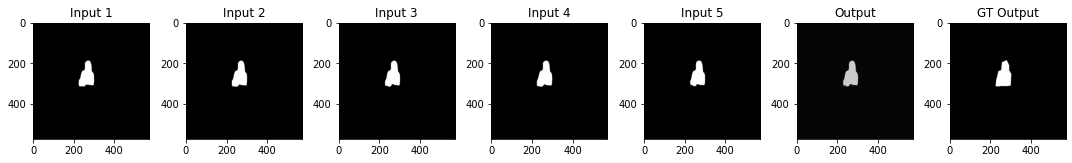

1.0 0.0
0.796432 0.02283014
[25,   150] loss: 0.051538


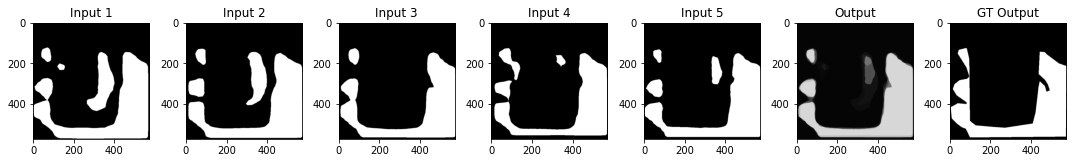

1.0 0.0
0.8425185 0.022893857
Finished Training
Starting training on network  [1, 1, 1]
[1,    50] loss: 0.672592


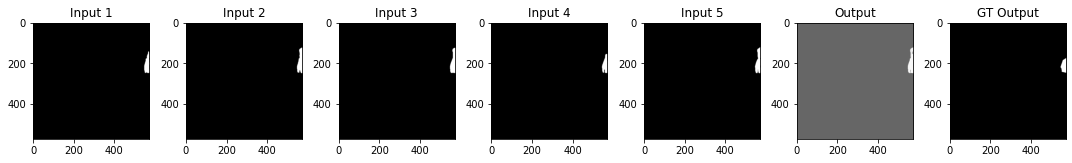

1.0 0.0
0.99966407 0.15613645
[1,   100] loss: 0.508985


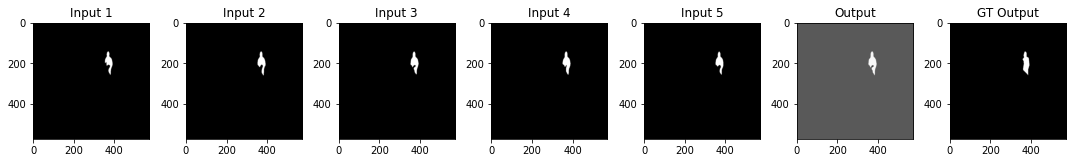

1.0 0.0
0.9984137 0.057412572
[1,   150] loss: 0.448919


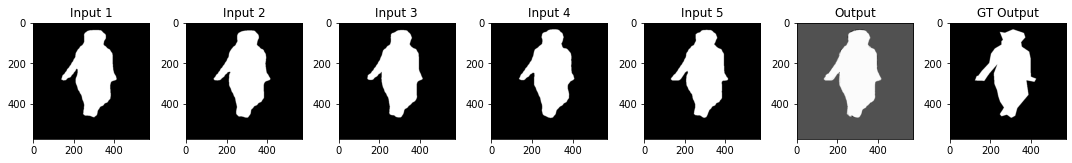

1.0 0.0
0.9994916 0.019264268
[2,    50] loss: 0.356399


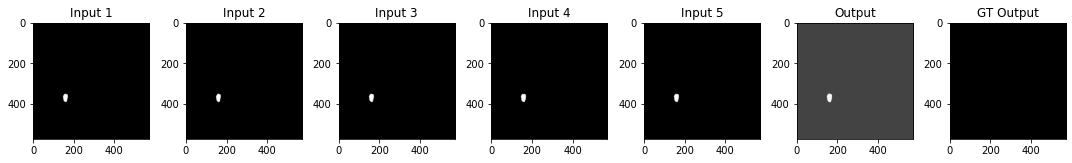

1.0 0.0
0.9848763 0.26509127
[2,   100] loss: 0.324805


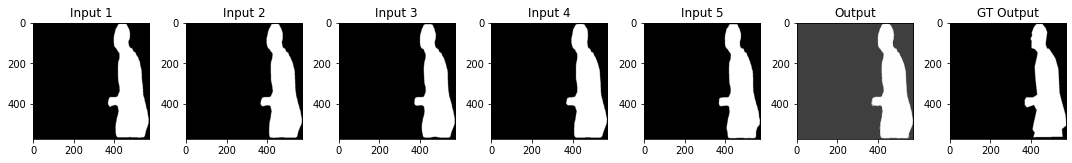

1.0 0.0
0.99954337 0.0031276648
[2,   150] loss: 0.295468


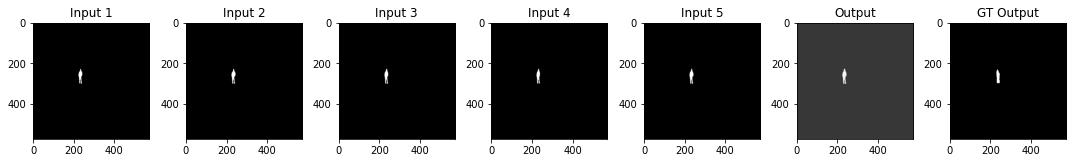

1.0 0.0
0.9869529 0.08732585
[3,    50] loss: 0.254017


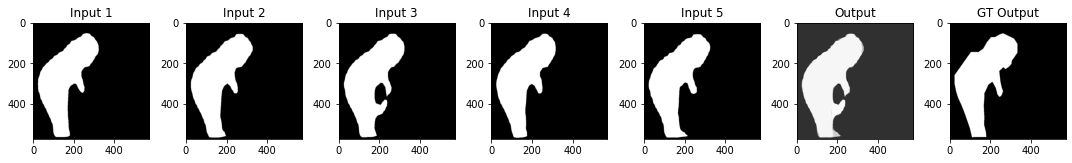

1.0 0.0
0.99236697 0.038110454
[3,   100] loss: 0.234676


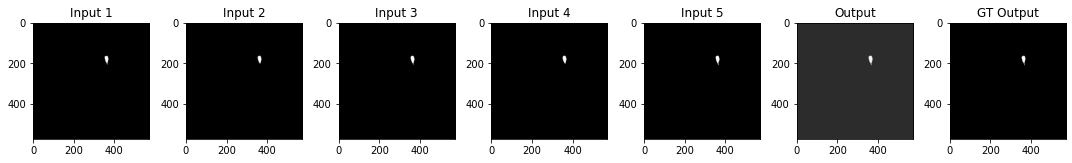

1.0 0.0
0.97167945 0.111662656
[3,   150] loss: 0.221133


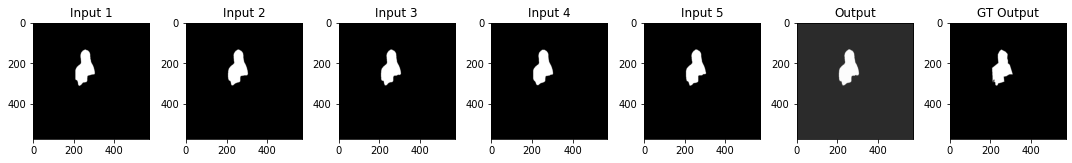

1.0 0.0
0.9977775 0.009139821
[4,    50] loss: 0.195890


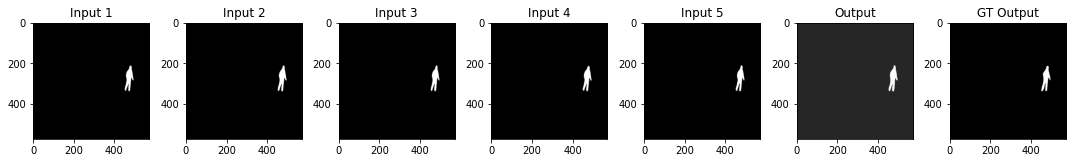

1.0 0.0
0.9923522 0.01383822
[4,   100] loss: 0.184144


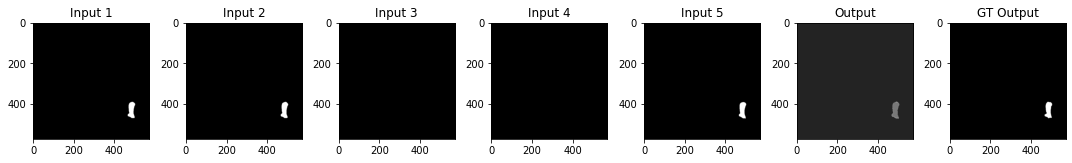

1.0 0.0
0.95807 0.079412326
[4,   150] loss: 0.172896


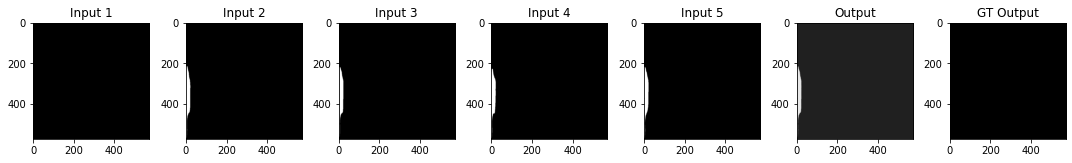

1.0 0.0
0.9683756 0.046695754
[5,    50] loss: 0.159581


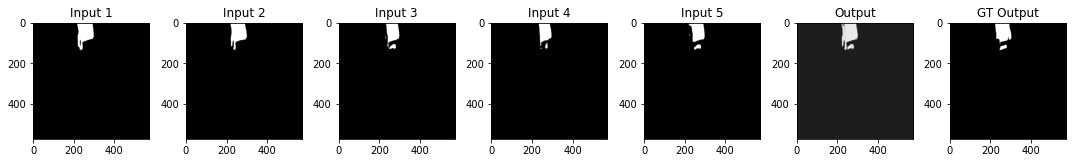

1.0 0.0
0.9643588 0.04567402
[5,   100] loss: 0.153451


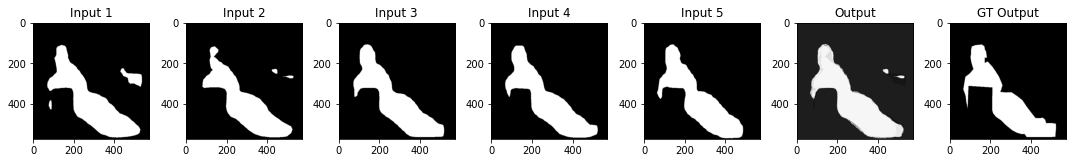

1.0 0.0
0.9894628 0.01693659
[5,   150] loss: 0.145734


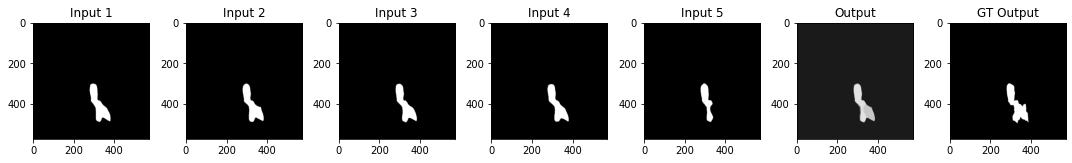

1.0 0.0
0.88714266 0.041800875
[6,    50] loss: 0.135846


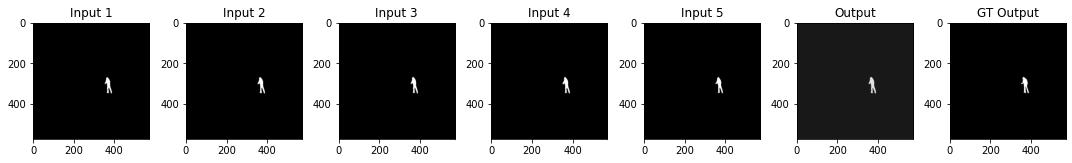

1.0 0.0
0.9028713 0.03319099
[6,   100] loss: 0.127307


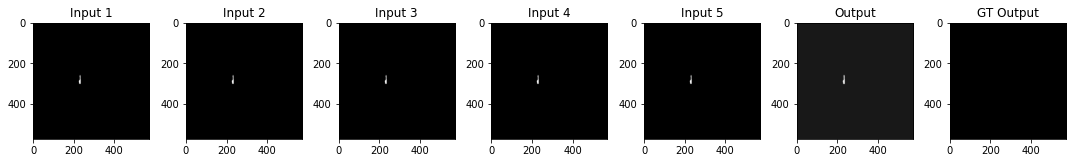

1.0 0.0
0.9214418 0.09382042
[6,   150] loss: 0.126807


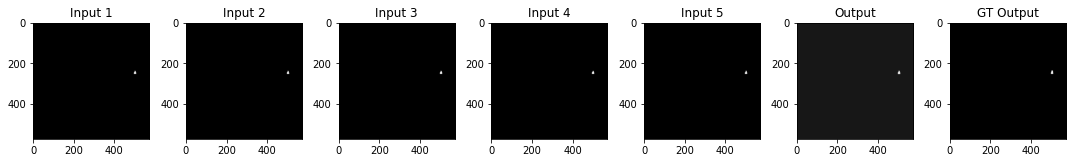

1.0 0.0
0.9248796 0.09030895
[7,    50] loss: 0.118680


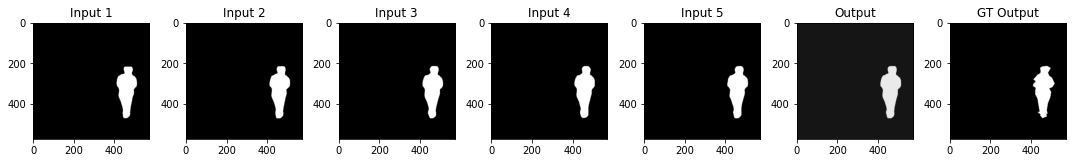

1.0 0.0
0.94387704 0.032039937
[7,   100] loss: 0.113669


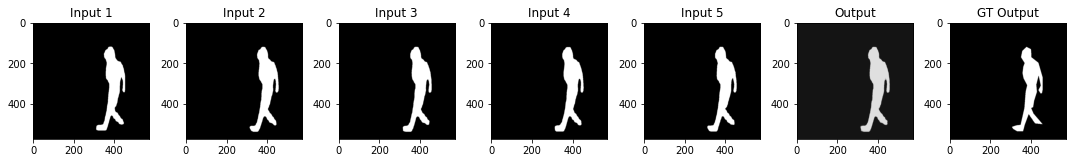

1.0 0.0
0.91263604 0.03541099
[7,   150] loss: 0.110723


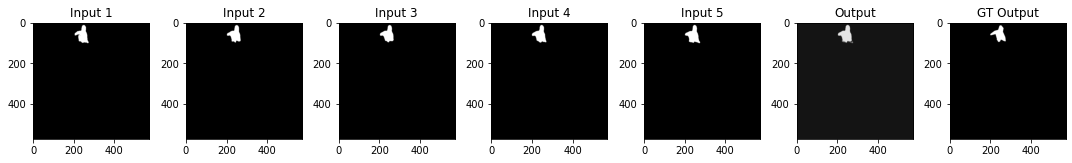

1.0 0.0
0.8989929 0.042344388
[8,    50] loss: 0.104445


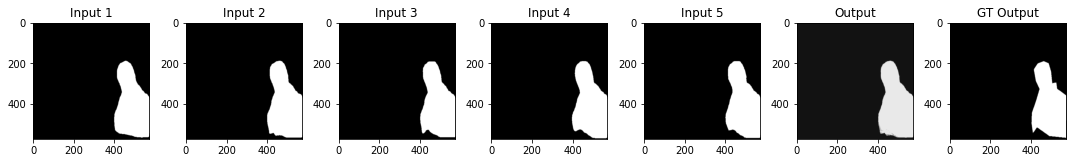

1.0 0.0
0.9273663 0.02660743
[8,   100] loss: 0.105649


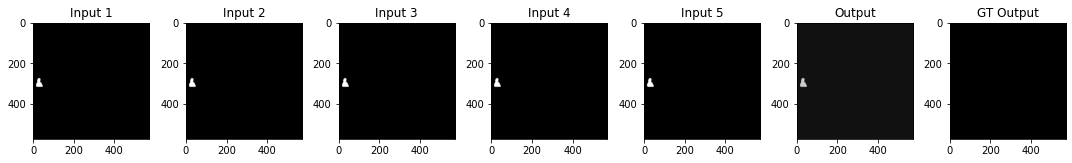

1.0 0.0
0.7986295 0.06877509
[8,   150] loss: 0.099026


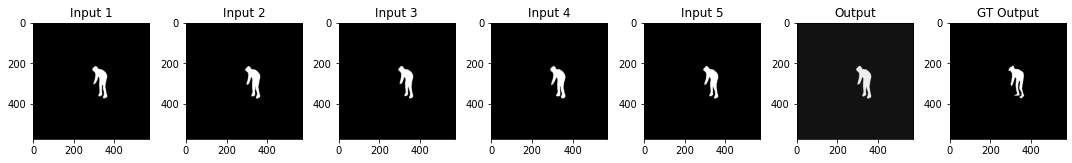

1.0 0.0
0.9427206 0.020268042
[9,    50] loss: 0.095303


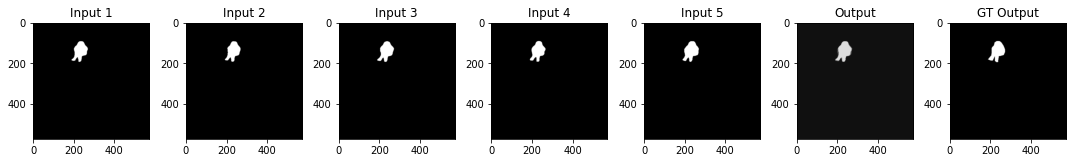

1.0 0.0
0.90691966 0.03264625
[9,   100] loss: 0.095161


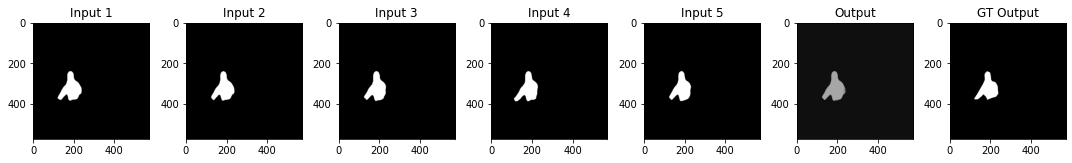

1.0 0.0
0.6699669 0.03868125
[9,   150] loss: 0.092000


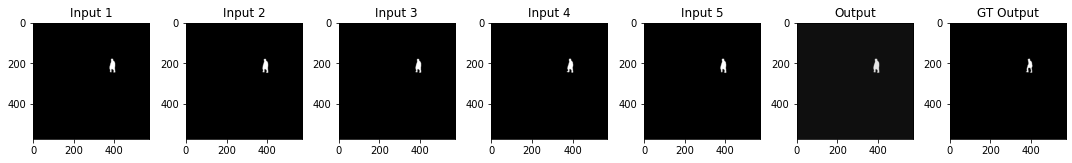

1.0 0.0
0.90621054 0.021537835
[10,    50] loss: 0.088053


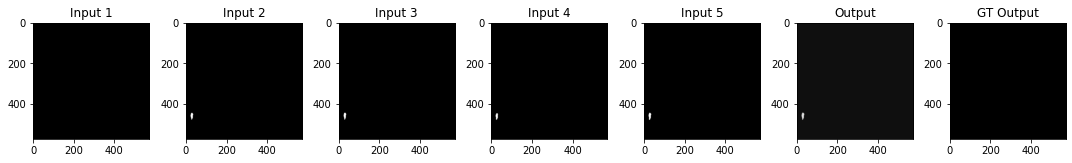

1.0 0.0
0.91303575 0.05961511
[10,   100] loss: 0.085968


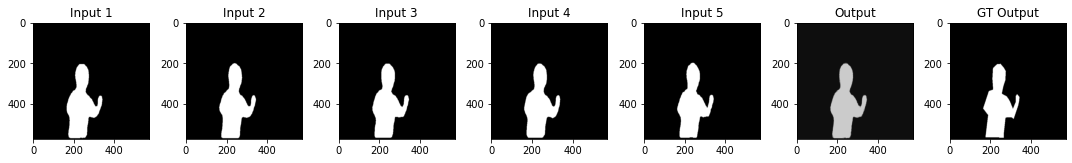

1.0 0.0
0.8278495 0.035640616
[10,   150] loss: 0.085571


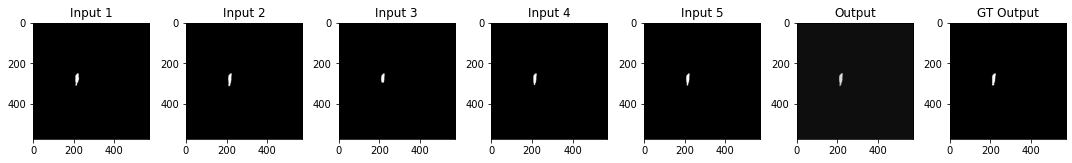

1.0 0.0
0.85207635 0.052812077
[11,    50] loss: 0.082114


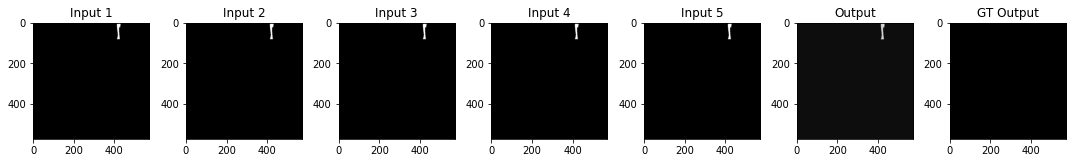

1.0 0.0
0.8283016 0.05315113


KeyboardInterrupt: 

In [8]:
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ACTIVATION = "sigmoid"
LOSS = "BCELoss"

for layers in [[1],[1,1,1],[3,3,3],[5,5,5]]:
    print("Starting training on network ",layers)
    
    net = SimpleNet(N_CHANNELS,layers,activation=ACTIVATION)
    net = net.to(device).float()
    criterion = nn.BCELoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    
    checkpoint_path = "work_dirs/simplenet"
    for layer in layers:
        checkpoint_path += "_"+str(layer)
    checkpoint_path += "/" + ACTIVATION + "_" + LOSS + "/"
    tensorboard_path = checkpoint_path+"tb/"
    os.makedirs(tensorboard_path,exist_ok=True)
    
    train(net,trainloader,criterion, optimizer, checkpoint_path, tensorboard_path)#, checkpoint="work_dirs/simplenet_1/epoch_25.pt")

In [9]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
event_acc = EventAccumulator('work_dirs/simplenet_1_1_1/sigmoid_BCELoss/tb')
event_acc.Reload()
# Show all tags in the log file
print(event_acc.Tags())

# E. g. get wall clock, number of steps and value for a scalar 'Accuracy'
w_times, step_nums, vals = zip(*event_acc.Scalars('Loss'))

{'images': [], 'audio': [], 'histograms': [], 'scalars': ['Loss'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}


# Network Summary

In [ ]:
from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNet(5,[1,1,1],activation="sigmoid").float().to(device)

summary(model, (1,5,572,572))

In [ ]:
# for i in range(1):
    data = trainset[i]
    
    im_seg = data['im_seg']
    im_res = data['im_res']
    
    res = im_seg[0:3,:,:].numpy().transpose((1,2,0))
    
    fig = plt.figure()
    plt.imshow(res)